# Convolutional Neural Networks with Pytorch 💻

Now that we have learned about the theory around convolutional neural networks, let's learn how to process images and build CNNs with Pytorch!

## What will you learn in this course? 🧐🧐

This lesson will focus on convolutional neural networks and the various layers that are often used in model architectures using convolutional neurons. We will start by giving a general introduction then move on to a demo with code, and additional ressources that help interpret what these models are "seeing".

* Image processing with Pytorch
  * Data augmentation
    * general principle
    * Manual data augmentation
    * ImageDataGenerator
      * from directory
      * from DataFrame
* Build a convolutional neural network with Pytorch
  * Conv1D, Conv2D, Conv3D layers
  * Pooling


## Image processing with Pytorch 🌆🌆

Now that you understand the general principle of how convolution layers work it is time to get into the details of how we will load and process images to build datasets with Pytorch.

First let's see how we can load a single image and convert it to a tensor.

In [8]:
# Let's load a single image with PyTorch
import torch
import torchvision.transforms as transforms
from PIL import Image
import requests
from io import BytesIO

device = torch.accelerator.current_accelerator().type if torch.accelerator.is_available() else "cpu"
print(f"Using {device} device")

Using mps device


In [36]:
torch.__version__

'2.6.0'

In [9]:
# Download the image
url = "https://full-stack-assets.s3.eu-west-3.amazonaws.com/images/M08-DeepLearning/flowers-324175_1920.jpg"
response = requests.get(url)
img = Image.open(BytesIO(response.content))
img.show()

In [10]:
img.show()

We get a tensor that contains a single `str` object, this is actually our image file represented in bytes, in order to get a numeric tensor with the values on each pixel we now need to decode this byte file according to its storage format (here it's jpeg but many other formats exist and there are special decoding functions for most of them)

In [11]:
# Convert the image to a tensor
transform = transforms.ToTensor()
img_tensor = transform(img)
print(img_tensor.shape)  # Shape: (C, H, W)

torch.Size([3, 1280, 1920])


We were able to decode the content of the image, now we have a numeric tensor of type `int` with shape `(1280,1920,3)` listing the height, width and number of channels of the image. We can visualize this image (spoiler alert, you have already seen it!) but let's resize it first as it is very very big!

In [12]:
# Resize the image using PyTorch transforms
resize_transform = transforms.Resize((img_tensor.shape[1] // 2, img_tensor.shape[2] // 2))
img_resized = resize_transform(img)
img_resized.show()

In [13]:
import plotly.express as px

In [14]:
px.imshow(img_resized)

The resize function is actually really useful because for most applications images really do not need to be in HD in order for the model to analyse them well, quite the opposite, the higher the definition of the images the more demanding the forward pass of your model will be, leading to exponentially growing computation time and memory you would need to handle the task.

To give you some perspective, even the best performing image classification models trained by institutions like Google work with images of shape `(224,224,3)` which is quite low definition. This good news because low definition images are easier to make, store and handle for computer programs and hardware.

### Data Augmentation ➕

Data augmentation is a very useful technique that makes it possible to artificially increase the amount of data you will be able to use for training and therefore lead to better prediction results.



### General principle 📜

The idea is the following: when you think of a classification task on images for example, your input data are images representing objects like dogs or cats or flowers, and the target variable indicates the category to which the image belongs to.

Imagine if you were to modify the image by flipping it horizontally or vertically, or change the contrast or brightness of the image slightly, would you still be able to recognize what category of the target the image belongs to? The answer is most certainly yes! Let's see for yourself

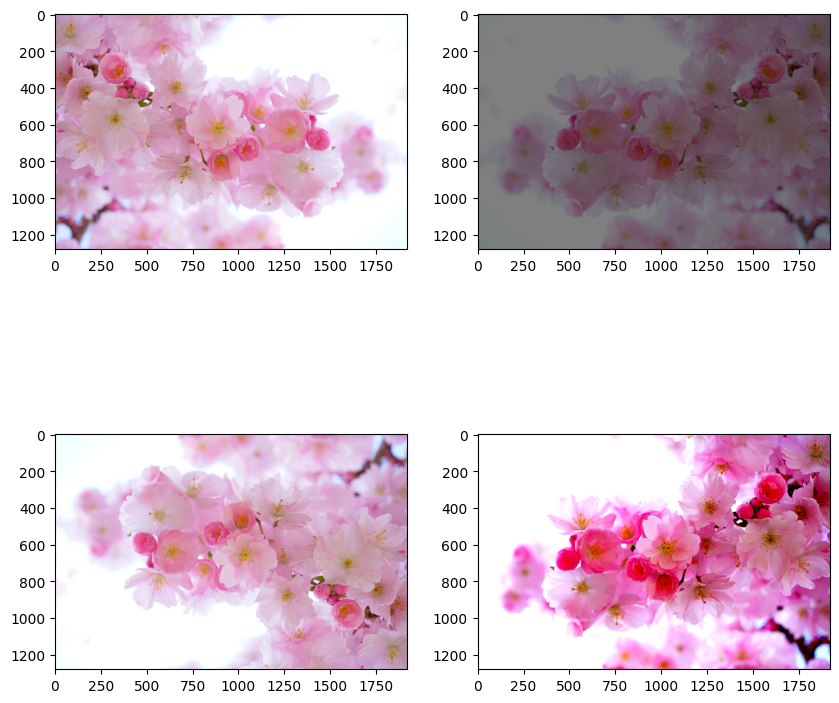

In [15]:
from torchvision.transforms import functional as F
import matplotlib.pyplot as plt

img2 = F.hflip(img)  # Flip horizontally
img3 = F.vflip(img)  # Flip vertically
img4 = F.adjust_brightness(img, 0.5)  # Change brightness
img5 = F.adjust_contrast(img, 2)  # Change contrast

fig, ax = plt.subplots(2, 2, figsize=(10, 10))
ax[0, 0].imshow(img2)
ax[1, 0].imshow(img3)
ax[0, 1].imshow(img4)
ax[1, 1].imshow(img5)
plt.show()

If you are still able to recognize the object represented in the image, in this case cherry blossom, then our data augmentation was successful. The value of the target variable is not affected by the transformations applied but if we were to compare those images with the computer, which does a pixel per pixel comparison, then they would seem very different.

This will allow our models to see many images representing the same object with different transformations and therefore teach the model to recognize images with many different characteristics.

We saw how to manually change the values in our images, now let's see how we can do that in a more automated fashion in order to build batch of images with data augmentation on demand!

### Image generator 🔋

Pytorch makes it very easy to run data augmentation on your image datasets! For this we will compose several transformations together we will later apply when loading our images.

In [16]:
from torchvision import datasets

transform = transforms.Compose([
    #transforms.RandomRotation(180),  # Rotate image randomly
    transforms.RandomHorizontalFlip(),  # Random horizontal flip
    transforms.RandomVerticalFlip(),  # Random vertical flip
    transforms.ColorJitter(brightness=0.5, contrast=0.5),  # Random color adjustments
    transforms.Resize([100,100]),
    transforms.ToTensor(),
])

Now that we know how to set up transformations, let's see two techniques that let us start producing images!

#### From directory 📁

This first method lets you load images as you go directly from a folder in your storage space. The folder needs to be organized in the following way:
```
├── Folder
│   ├── Class1
│   │   ├── Image1.jpg
│   │   ├── Image2.jpg
│   │   ├── ...
│   │   └── ImageN.jpg
│   ├── Class2
│   │   ├── Image1.jpg
│   │   ├── Image2.jpg
│   │   ├── ...
│   │   └── ImageN.jpg
│   ├── ...
│   └── ClassP
│       ├── Image1.jpg
│       ├── Image2.jpg
│       ├── ...
│       └── ImageN.jpg
  ```       

Then what will happen is that when generating images, the generator will go pick the images from the different folders at random, apply the random transformations that were previously set up and associate to each generated image a value for the target variable corresponding to the name of the folder it was extracted from!

Let's see how it works in practice!

In [17]:
import os
import requests
import zipfile

# Define the URL and the output path
url = "https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip"
output_path = "cats_and_dogs_filtered.zip"
extract_dir = "./cats_and_dogs_filtered"
def load_and_extract_files(url,output_path,extract_dir):
    # Download the dataset
    if not os.path.exists(output_path):
        response = requests.get(url, stream=True)
        with open(output_path, "wb") as file:
            for chunk in response.iter_content(chunk_size=1024):
                if chunk:
                    file.write(chunk)
        print("Download complete.")

    # Extract the dataset
    if not os.path.exists(extract_dir):
        with zipfile.ZipFile(output_path, "r") as zip_ref:
            zip_ref.extractall("./")
        print("Extraction complete.")

load_and_extract_files(url,output_path,extract_dir)

We are going to usea method of the generator object that will let us create images from the folder.

In [18]:
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader

# Load dataset
train_dataset = ImageFolder(root="cats_and_dogs_filtered/train", transform=transform)
val_dataset = ImageFolder(root="cats_and_dogs_filtered/validation", transform=transform)

# Create DataLoader
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=True)

In [19]:
img, label = next(iter(train_loader))

In [20]:
img.shape

torch.Size([16, 3, 100, 100])

The method automatically identified all the images contained in the directory and the number of classes was infered from the number of sub-directories inside it.

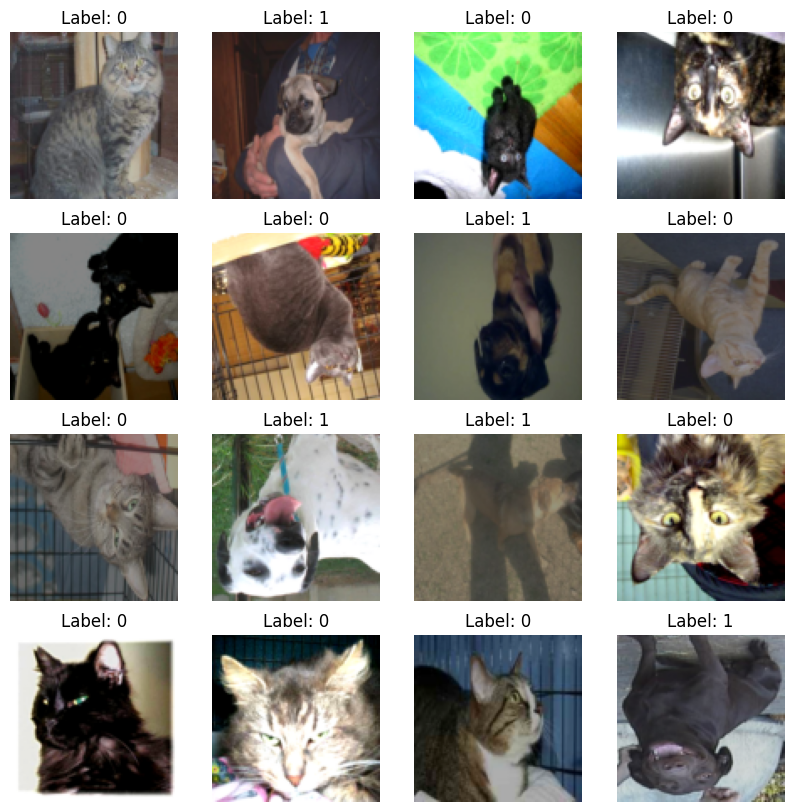

In [21]:
# Get a batch of images
images, labels = next(iter(train_loader))

# Convert tensor to numpy for visualization
fig, ax = plt.subplots(4, 4, figsize=(10, 10))
for i in range(16):
    img = images[i].permute(1, 2, 0).numpy()
    ax[i // 4, i % 4].imshow(img)
    ax[i // 4, i % 4].set_title(f"Label: {labels[i]}")
    ax[i // 4, i % 4].axis("off")

plt.show()

This an example of a batch of images generated with data augmentation. Which will make it possible to train the model on a virtually unlimited variety of images taken from a finite set of examples so the model will be better at generalizing its prediction to unseen data.

#### From DataFrame 📊

This other method lets you generate images in the same way, except the images can all be stored in a single directory, the labels associated with each image in this case is stored in a DataFrame object contaning the name of each image file in one column and the value of the target in the second column. Let's find out how to work with this in practice

In [22]:
# First we download the .zip file containing all the images

load_and_extract_files(url="https://full-stack-assets.s3.eu-west-3.amazonaws.com/datasets/M08/cifar-10/train.zip",
                         output_path="./cifar10.zip",
                         extract_dir="./cifar10")

Extraction complete.


In [23]:
import pandas as pd
from torch.utils.data import Dataset
import os

# Load the dataset from CSV
data = pd.read_csv("https://full-stack-assets.s3.eu-west-3.amazonaws.com/datasets/M08/cifar-10/trainLabels.csv")
data["id"] = data["id"].astype(str) + ".png"
data.head()

,id,label
0,1.png,frog
1,2.png,truck
2,3.png,truck
3,4.png,deer
4,5.png,automobile


In [ ]:
# Define a custom PyTorch Dataset
class ImageDataset(Dataset):
    def __init__(self, dataframe, img_dir, transform=None):
        self.dataframe = dataframe
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_name = os.path.join(self.img_dir, self.dataframe.iloc[idx, 0])
        image = Image.open(img_name)
        label = self.dataframe.iloc[idx, 1]
        if self.transform:
            image = self.transform(image)
        return image, label

# Create dataset and dataloader
df_dataset = ImageDataset(dataframe=data, img_dir="./train", transform=transform)
df_loader = DataLoader(df_dataset, batch_size=16, shuffle=True)

In [25]:
images.shape

torch.Size([16, 3, 100, 100])

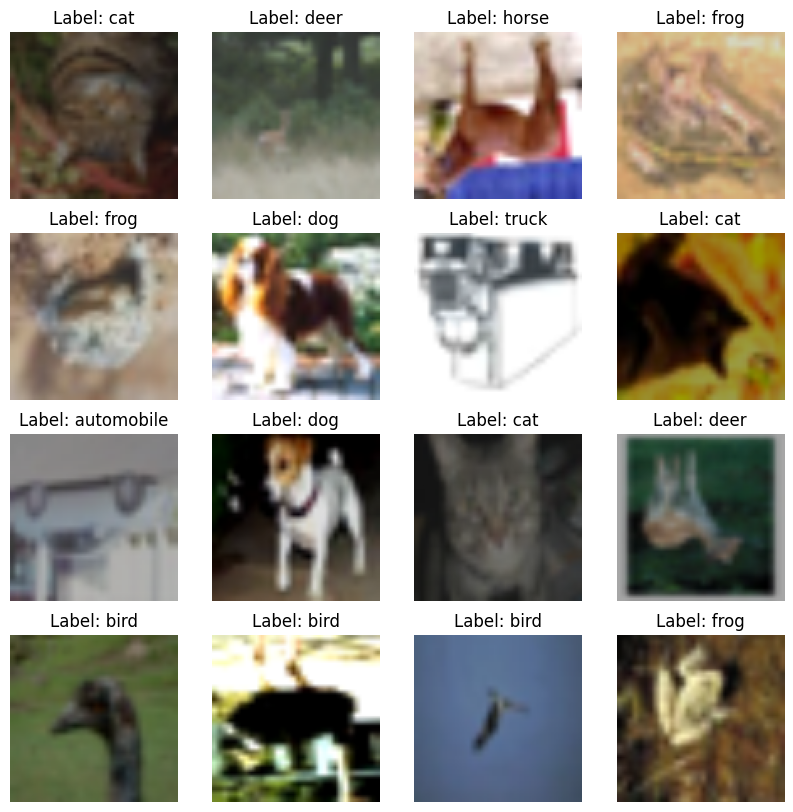

In [26]:
images, labels = next(iter(df_loader))
fig, ax = plt.subplots(4, 4, figsize=(10, 10))
for i in range(16):
    img = images[i].permute(1, 2, 0).numpy()
    ax[i // 4, i % 4].imshow(img)
    ax[i // 4, i % 4].set_title(f"Label: {labels[i]}")
    ax[i // 4, i % 4].axis("off")

plt.show()

These two techniques enable you to easily produce images from either a directory organized by labels or using an external dataframe containing the values for the target variable.

## Build a convolutional neural network with Pytorch 💹💹
 Now that we know how to build image datasets, let's learn how to build convolutional neural networks with Pytorch.

### Conv1D, Conv2D, Conv3D ✖️

In order to build convolutional Neural Networks we need to learn about some new layers from `Pytorch.keras.layers`.

Before we move on to coding, one quick word about the various types of convolution. This lecture focuses mainly on bidimensional convolution because we are going to work with images which are bidemensional objects, but the convolution principle may also be applied to unidimensional like sound or time series and tridimensional objects such as 3D-images or videos (for videos the three dimensions are width length and time). The idea is the same except that the shape of the filter will be different, for 1D convolution the shape of the filter will be `(3)` for example, and for 3D convolution the shape will be `(3,3,3)` for example.

Now let's move on to code!

In [27]:
import torch
import torch.nn as nn

# Define convolutional layers
conv1d = nn.Conv1d(
    in_channels=1, # number of input channels e.g. a colored image has 3 channels, the output of a conv layer with 64 neurons has 64 channels
    out_channels=16, # the number of output chennels corresponds to the number of filters or number of neurons on the layers
    kernel_size=5, # the width and height of each convolution filter
    stride=1, # the number of steps taken for each movement of the filter
    padding=0 # the number of padding cells around the input
    # padding="same" stride="1" for output_shape = input_shape
    # padding="valid" for minimum viable padding
)

conv2d = nn.Conv2d(
    in_channels=3, out_channels=16, kernel_size=(3,3), stride=1, padding=0
)

conv3d = nn.Conv3d(
    in_channels=3, out_channels=16, kernel_size=(3,3,3), stride=1, padding=0
)

Let's make an example of a simple convolutional neural network that we will train on the cats and dogs dataset!

In [28]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=2, padding=1)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=2, padding=1)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=2, padding=1)
        self.conv4 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=2, padding=1)
        self.flatten = nn.Flatten()
        self.fc = nn.Linear(128 * 7 * 7, 1)  # Adjust the size based on input shape
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = torch.relu(self.conv2(x))
        x = torch.relu(self.conv3(x))
        x = torch.relu(self.conv4(x))
        x = self.flatten(x)
        x = self.sigmoid(self.fc(x))
        return x

# Instantiate model
model = CNN()

In [29]:
print(model)

CNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (conv3): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (conv4): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc): Linear(in_features=6272, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)


Herewe set the stride to 2 on purpose so that the inputs of each layer gets transformed into an output twice as small.

In [30]:
pip install torchinfo

Note: you may need to restart the kernel to use updated packages.


In [31]:
from torchinfo import summary

# Print model summary
summary(model, input_size=(1, 3, 100, 100))  # (batch_size, input_features)

Layer (type:depth-idx)                   Output Shape              Param #
CNN                                      [1, 1]                    --
├─Conv2d: 1-1                            [1, 32, 50, 50]           896
├─Conv2d: 1-2                            [1, 64, 25, 25]           18,496
├─Conv2d: 1-3                            [1, 64, 13, 13]           36,928
├─Conv2d: 1-4                            [1, 128, 7, 7]            73,856
├─Flatten: 1-5                           [1, 6272]                 --
├─Linear: 1-6                            [1, 1]                    6,273
├─Sigmoid: 1-7                           [1, 1]                    --
Total params: 136,449
Trainable params: 136,449
Non-trainable params: 0
Total mult-adds (M): 23.67
Input size (MB): 0.12
Forward/backward pass size (MB): 1.10
Params size (MB): 0.55
Estimated Total Size (MB): 1.76

In [32]:
(3*3*3 +1)*32

896

In [33]:
(3*3*32 + 1)*64

18496

Now that the model is defined we need to define the loss function, the optimizer, and start training.

In [34]:
import torch.optim as optim

criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
from torch.utils.data import DataLoader

model.to(device)

def train(model, train_loader, val_loader, criterion, optimizer, epochs=100):
    """
    Function to train a PyTorch model with training and validation datasets.

    Parameters:
    model: The neural network model to train.
    train_loader: DataLoader for the training dataset.
    val_loader: DataLoader for the validation dataset.
    criterion: Loss function (e.g., Binary Cross Entropy for classification).
    optimizer: Optimization algorithm (e.g., Adam, SGD).
    epochs: Number of training epochs (default=100).

    Returns:
    history: Dictionary containing loss and accuracy for both training and validation.
    """

    # Dictionary to store training & validation loss and accuracy over epochs
    history = {'loss': [], 'val_loss': [], 'accuracy': [], 'val_accuracy': []}

    for epoch in range(epochs):  # Loop over the number of epochs
        model.train()  # Set model to training mode
        total_loss, correct = 0, 0  # Initialize total loss and correct predictions

        # Training loop
        for inputs, labels in train_loader:
            optimizer.zero_grad()  # Reset gradients before each batch
            model.to(device)
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs).squeeze()  # Forward pass
            loss = criterion(outputs, labels.float())  # Compute loss
            loss.backward()  # Backpropagation (compute gradients)
            optimizer.step()  # Update model parameters

            total_loss += loss.item()  # Accumulate batch loss
            correct += ((outputs > 0.5) == labels).sum().item()  # Count correct predictions

        # Compute average loss and accuracy for training
        train_loss = total_loss / len(train_loader)
        train_acc = correct / len(train_loader.dataset)

        # Validation phase (without gradient computation)
        model.eval()  # Set model to evaluation mode
        val_loss, val_correct = 0, 0
        with torch.no_grad():  # No need to compute gradients during validation
            for inputs, labels in val_loader:
                model.to(device)
                inputs = inputs.to(device)
                labels = labels.to(device)
                outputs = model(inputs).squeeze()  # Forward pass
                loss = criterion(outputs, labels.float())  # Compute loss
                val_loss += loss.item()  # Accumulate validation loss
                val_correct += ((outputs > 0.5) == labels).sum().item()  # Count correct predictions

        # Compute average loss and accuracy for validation
        val_loss /= len(val_loader)
        val_acc = val_correct / len(val_loader.dataset)

        # Store metrics in history dictionary
        history['loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        history['accuracy'].append(train_acc)
        history['val_accuracy'].append(val_acc)

        # Print training progress
        print(f"Epoch [{epoch+1}/{epochs}], Loss: {train_loss:.4f}, Acc: {train_acc:.4f}, "
              f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

    return history  # Return training history

history = train(model,
                train_loader=train_loader,
                val_loader=val_loader,
                criterion=criterion,
                optimizer=optimizer,
                epochs=40)


Epoch [1/40], Loss: 0.6942, Acc: 0.5100, Val Loss: 0.6930, Val Acc: 0.5690
Epoch [2/40], Loss: 0.6936, Acc: 0.5210, Val Loss: 0.6929, Val Acc: 0.5160
Epoch [3/40], Loss: 0.6925, Acc: 0.4975, Val Loss: 0.6930, Val Acc: 0.5390
Epoch [4/40], Loss: 0.6917, Acc: 0.5315, Val Loss: 0.6903, Val Acc: 0.5420
Epoch [5/40], Loss: 0.6899, Acc: 0.5295, Val Loss: 0.6902, Val Acc: 0.5370
Epoch [6/40], Loss: 0.6885, Acc: 0.5445, Val Loss: 0.6893, Val Acc: 0.5460


KeyboardInterrupt: 

In [35]:
# Save model checkpoint
checkpoint_path = "model_stride.pth"
torch.save({
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'val_loss': history["val_loss"][-1],
}, checkpoint_path)

NameError: name 'history' is not defined

In [ ]:
url="https://full-stack-assets.s3.eu-west-3.amazonaws.com/M08-deep-learning/model_stride.pth"
output_path="model_stride.pth"

# Download the file
if not os.path.exists(output_path):
    response = requests.get(url, stream=True)
    with open(output_path, "wb") as file:
        for chunk in response.iter_content(chunk_size=1024):
            if chunk:
                file.write(chunk)
    print("Download complete.")

Download complete.


In [ ]:
restored_model = CNN()  # Ensure the same architecture
restored_model.load_state_dict(torch.load("model_stride.pth", weights_only=True)["model_state_dict"])
restored_model.eval()

CNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (conv3): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (conv4): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc): Linear(in_features=6272, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)

In [ ]:
from plotly import graph_objects as go
color_chart = ["#4B9AC7", "#4BE8E0", "#9DD4F3", "#97FBF6", "#2A7FAF", "#23B1AB", "#0E3449", "#015955"]

fig = go.Figure(data=[
                      go.Scatter(
                          y=history["loss"],
                          name="Training loss",
                          mode="lines",
                          marker=dict(
                              color=color_chart[0]
                          )),
                      go.Scatter(
                          y=history["val_loss"],
                          name="Validation loss",
                          mode="lines",
                          marker=dict(
                              color=color_chart[1]
                          ))
])
fig.update_layout(
    title='Training and val loss across epochs',
    xaxis_title='epochs',
    yaxis_title='Cross Entropy'
)
fig.show()

NameError: name 'history' is not defined

This graph shows the evolution of the loss during 100 epochs of training. The fact that the loss is very unstable comes from the fact that we generate new images at each new epoch thanks to the generator so it is hard for the model to train because of all the variations we include in the images it's training from. But that is actually a good thing because it also prevents it from over fitting and forces it to recognize images from lots of different angles and shapes!

### Pooling 🏊

Let's define a new network using some pooling. Pooling layers are very often included in convolutional neural network achitectures because they make it possible to summarize information extracted by convolutional layers without having a stride higher than 1, which lets convolutional layers gather information from more positions in the input image!

In [ ]:
class CNNWithPooling(nn.Module):
    def __init__(self):
        super(CNNWithPooling, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv4 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1)
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.flatten = nn.Flatten()
        self.fc = nn.Linear(128 * 6 * 6, 1)  # Adjust the size based on input shape
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = self.pool1(x)
        x = torch.relu(self.conv2(x))
        x = self.pool2(x)
        x = torch.relu(self.conv3(x))
        x = self.pool3(x)
        x = torch.relu(self.conv4(x))
        x = self.pool4(x)
        x = self.flatten(x)
        x = self.sigmoid(self.fc(x))
        return x

# Instantiate and train model with pooling
model_pooling = CNNWithPooling()


In [ ]:
from torchinfo import summary

# Print model summary
summary(model_pooling, input_size=(1, 3, 100, 100))  # (batch_size, input_features)

Layer (type:depth-idx)                   Output Shape              Param #
CNNWithPooling                           [1, 1]                    --
├─Conv2d: 1-1                            [1, 32, 100, 100]         896
├─MaxPool2d: 1-2                         [1, 32, 50, 50]           --
├─Conv2d: 1-3                            [1, 64, 50, 50]           18,496
├─MaxPool2d: 1-4                         [1, 64, 25, 25]           --
├─Conv2d: 1-5                            [1, 64, 25, 25]           36,928
├─MaxPool2d: 1-6                         [1, 64, 12, 12]           --
├─Conv2d: 1-7                            [1, 128, 12, 12]          73,856
├─MaxPool2d: 1-8                         [1, 128, 6, 6]            --
├─Flatten: 1-9                           [1, 4608]                 --
├─Linear: 1-10                           [1, 1]                    4,609
├─Sigmoid: 1-11                          [1, 1]                    --
Total params: 134,785
Trainable params: 134,785
Non-trainable params:

In [ ]:
import torch.optim as optim

criterion = nn.BCELoss()
optimizer_pooling = optim.Adam(model_pooling.parameters(), lr=0.001)


history_pooling = train(model_pooling, train_loader, val_loader, criterion, optimizer_pooling, epochs=40)

Epoch [1/40], Loss: 0.6937, Acc: 0.4900, Val Loss: 0.6931, Val Acc: 0.5230
Epoch [2/40], Loss: 0.6936, Acc: 0.5090, Val Loss: 0.6930, Val Acc: 0.5000
Epoch [3/40], Loss: 0.6945, Acc: 0.4945, Val Loss: 0.6929, Val Acc: 0.5000
Epoch [4/40], Loss: 0.6885, Acc: 0.5245, Val Loss: 0.6918, Val Acc: 0.5080
Epoch [5/40], Loss: 0.6943, Acc: 0.5205, Val Loss: 0.6925, Val Acc: 0.5250
Epoch [6/40], Loss: 0.6868, Acc: 0.5305, Val Loss: 0.6931, Val Acc: 0.5390
Epoch [7/40], Loss: 0.6929, Acc: 0.5190, Val Loss: 0.6882, Val Acc: 0.5300
Epoch [8/40], Loss: 0.6879, Acc: 0.5430, Val Loss: 0.6896, Val Acc: 0.5160
Epoch [9/40], Loss: 0.6666, Acc: 0.5935, Val Loss: 0.6523, Val Acc: 0.6170
Epoch [10/40], Loss: 0.6395, Acc: 0.6350, Val Loss: 0.6485, Val Acc: 0.6210
Epoch [11/40], Loss: 0.6340, Acc: 0.6385, Val Loss: 0.6464, Val Acc: 0.6260
Epoch [12/40], Loss: 0.6168, Acc: 0.6700, Val Loss: 0.6585, Val Acc: 0.6110
Epoch [13/40], Loss: 0.6317, Acc: 0.6265, Val Loss: 0.6254, Val Acc: 0.6400
Epoch [14/40], Loss: 

In [ ]:
# Save model checkpoint
checkpoint_path = "model_pooling.pth"
torch.save({
    'model_state_dict': model_pooling.state_dict(),
    'optimizer_state_dict': optimizer_pooling.state_dict(),
    'val_loss': history_pooling["val_loss"][-1],
}, checkpoint_path)

In [ ]:
url="https://full-stack-assets.s3.eu-west-3.amazonaws.com/M08-deep-learning/model_pooling.pth"
output_path="model_pooling.pth"

# Download the file
if not os.path.exists(output_path):
    response = requests.get(url, stream=True)
    with open(output_path, "wb") as file:
        for chunk in response.iter_content(chunk_size=1024):
            if chunk:
                file.write(chunk)
    print("Download complete.")

Download complete.


In [ ]:
restored_model_pooling = CNNWithPooling()  # Ensure the same architecture
restored_model_pooling.load_state_dict(torch.load("model_pooling.pth", weights_only=True)["model_state_dict"])
restored_model_pooling.eval()

CNNWithPooling(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc): Linear(in_features=4608, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)

In [ ]:
from plotly import graph_objects as go
color_chart = ["#4B9AC7", "#4BE8E0", "#9DD4F3", "#97FBF6", "#2A7FAF", "#23B1AB", "#0E3449", "#015955"]

fig = go.Figure(data=[
                      go.Scatter(
                          y=history_pooling["loss"],
                          name="Training loss",
                          mode="lines",
                          marker=dict(
                              color=color_chart[0]
                          )),
                      go.Scatter(
                          y=history_pooling["val_loss"],
                          name="Validation loss",
                          mode="lines",
                          marker=dict(
                              color=color_chart[1]
                          ))
])
fig.update_layout(
    title='Training and val loss across epochs',
    xaxis_title='epochs',
    yaxis_title='Cross Entropy'
)
fig.show()

Here we notice something very interesting, the model starts overfitting around epoch 20 for both examples, however, using pooling helped us reach lower validation loss.